In [2]:
# ============================================================
# 02_model_training_and_evaluation.ipynb
# ------------------------------------------------------------
# Goal:
#   - Train predictive models to estimate salaries
#   - Evaluate and compare model performance
#   - Save the best-performing model for deployment
# ------------------------------------------------------------
# Input:  data/processed/cleaned_salary_data.csv
# Output: app/model.pkl
# ============================================================

# === 1. Imports and Setup ===
import pandas as pd
import numpy as np
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)


In [3]:
# === 2. Load Cleaned Dataset ===
DATA_PATH = "../data/processed/cleaned_salary_data.csv"
df = pd.read_csv(DATA_PATH)

print(f"✅ Loaded cleaned dataset: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()


✅ Loaded cleaned dataset: 742 rows, 68 columns


,Job Title,Rating,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,...,job_state_or,job_state_pa,job_state_ri,job_state_sc,job_state_tn,job_state_tx,job_state_ut,job_state_va,job_state_wa,job_state_wi
0,data scientist,3.8,"albuquerque, nm","goleta, ca",501 to 1000 employees,1973.0,company - private,aerospace & defense,aerospace & defense,$50 to $100 million (usd),...,False,False,False,False,False,False,False,False,False,False
1,healthcare data scientist,3.4,"linthicum, md","baltimore, md",10000+ employees,1984.0,other organization,health care services & hospitals,health care,$2 to $5 billion (usd),...,False,False,False,False,False,False,False,False,False,False
2,data scientist,4.8,"clearwater, fl","clearwater, fl",501 to 1000 employees,2010.0,company - private,security services,business services,$100 to $500 million (usd),...,False,False,False,False,False,False,False,False,False,False
3,data scientist,3.8,"richland, wa","richland, wa",1001 to 5000 employees,1965.0,government,energy,"oil, gas, energy & utilities",$500 million to $1 billion (usd),...,False,False,False,False,False,False,False,False,True,False
4,data scientist,2.9,"new york, ny","new york, ny",51 to 200 employees,1998.0,company - private,advertising & marketing,business services,unknown / non-applicable,...,False,False,False,False,False,False,False,False,False,False


In [7]:
# === 3. Define Features and Target ===
target_col = "avg_salary"

# Drop target + obvious non-feature columns
X = df.drop(columns=[target_col, "min_salary", "max_salary", "Unnamed: 0"], errors="ignore")
y = df[target_col]

# ---- Step 1: Detect non-numeric columns before encoding ----
non_numeric_cols_before = X.select_dtypes(include=["object"]).columns.tolist()
print(f"🧩 Non-numeric columns before encoding ({len(non_numeric_cols_before)}):", non_numeric_cols_before)

# ---- Step 2: One-hot encode categorical columns ----
X = pd.get_dummies(X, drop_first=True)

# ---- Step 3: Detect columns that are still not numeric ----
non_numeric_after = [col for col in X.columns if not np.issubdtype(X[col].dtype, np.number)]
if len(non_numeric_after) == 0:
    print("✅ After encoding, all feature columns are numeric.")
else:
    print(f"⚠️ {len(non_numeric_after)} columns are still non-numeric:")
    for col in non_numeric_after:
        unique_types = X[col].apply(lambda v: type(v).__name__).unique()
        num_missing = X[col].isna().sum()
        print(f"   - {col} (types: {list(unique_types)}, NaNs: {num_missing})")

# ---- Step 4: Handle remaining non-numeric or missing values ----
# Fill NaNs with 0 or appropriate value
X = X.fillna(0)

# Optional: Drop non-numeric leftovers (safety net)
X = X.select_dtypes(include=[np.number])

# ---- Step 5: Train/test split ----
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]},  Test samples: {X_test.shape[0]}")


🧩 Non-numeric columns before encoding (8): ['Job Title', 'Location', 'Headquarters', 'Size', 'Type of ownership', 'Industry', 'Sector', 'Revenue']
⚠️ 817 columns are still non-numeric:
   - job_simp_data engineer (types: ['bool'], NaNs: 0)
   - job_simp_data scientist (types: ['bool'], NaNs: 0)
   - job_simp_director (types: ['bool'], NaNs: 0)
   - job_simp_manager (types: ['bool'], NaNs: 0)
   - job_simp_mle (types: ['bool'], NaNs: 0)
   - job_simp_na (types: ['bool'], NaNs: 0)
   - seniority_na (types: ['bool'], NaNs: 0)
   - seniority_senior (types: ['bool'], NaNs: 0)
   - job_state_az (types: ['bool'], NaNs: 0)
   - job_state_ca (types: ['bool'], NaNs: 0)
   - job_state_co (types: ['bool'], NaNs: 0)
   - job_state_ct (types: ['bool'], NaNs: 0)
   - job_state_dc (types: ['bool'], NaNs: 0)
   - job_state_de (types: ['bool'], NaNs: 0)
   - job_state_fl (types: ['bool'], NaNs: 0)
   - job_state_ga (types: ['bool'], NaNs: 0)
   - job_state_ia (types: ['bool'], NaNs: 0)
   - job_state_id

In [8]:
# Check which columns are non-numeric
non_numeric = X.select_dtypes(include=["object"]).columns
print("🧩 Non-numeric columns found:", list(non_numeric))

🧩 Non-numeric columns found: []


In [9]:
# === 4. Train Models ===
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse})
    print(f"{name}:  R²={r2:.3f},  MAE={mae:.2f},  RMSE={rmse:.2f}")


Linear Regression:  R²=0.215,  MAE=28.28,  RMSE=35.81
Random Forest:  R²=0.624,  MAE=16.34,  RMSE=24.78
Gradient Boosting:  R²=0.556,  MAE=20.38,  RMSE=26.95


In [10]:
# === 5. Compare Model Performance ===
results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False).reset_index(drop=True)
results_df


,Model,R2,MAE,RMSE
0,Random Forest,0.624203,16.338087,24.783970
1,Gradient Boosting,0.555568,20.384305,26.952360
2,Linear Regression,0.215331,28.283981,35.812713


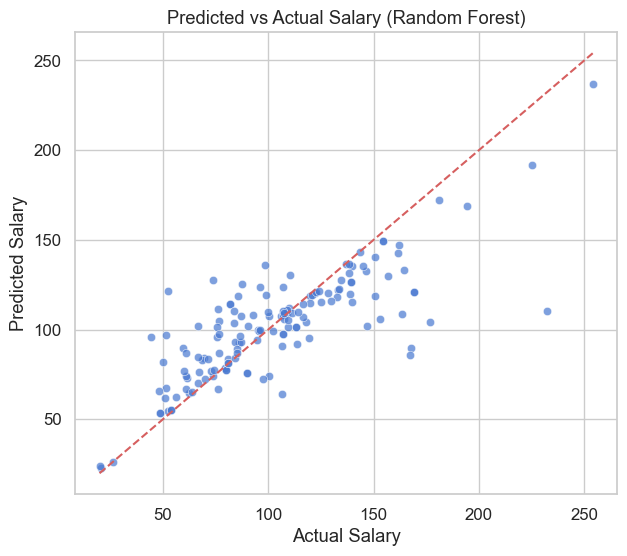

In [11]:
# === 6. Visualize Predicted vs Actual ===
best_model_name = results_df.loc[0, "Model"]
best_model = models[best_model_name]

y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"Predicted vs Actual Salary ({best_model_name})")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.show()


In [12]:
# === 7. Save Best Model ===
os.makedirs("app", exist_ok=True)
model_path = "app/model.pkl"
joblib.dump(best_model, model_path)

print(f"✅ Saved best model ({best_model_name}) to {model_path}")


✅ Saved best model (Random Forest) to app/model.pkl


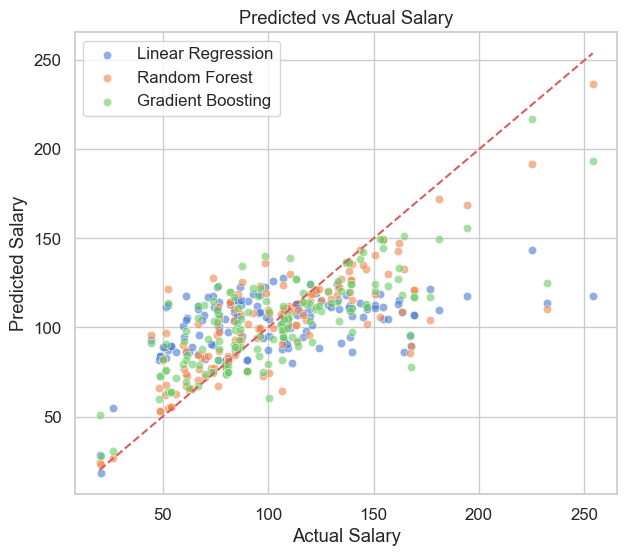

In [13]:
# === Predicted vs Actual Comparison for All Models ===
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,6))
for name, model in models.items():
    y_pred = model.predict(X_test)
    sns.scatterplot(x=y_test, y=y_pred, label=name, alpha=0.6)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs Actual Salary")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.legend()
plt.show()


Interpretation:
Points close to the red dashed line = accurate predictions
Random Forest points should cluster tighter along the diagonal → better calibration

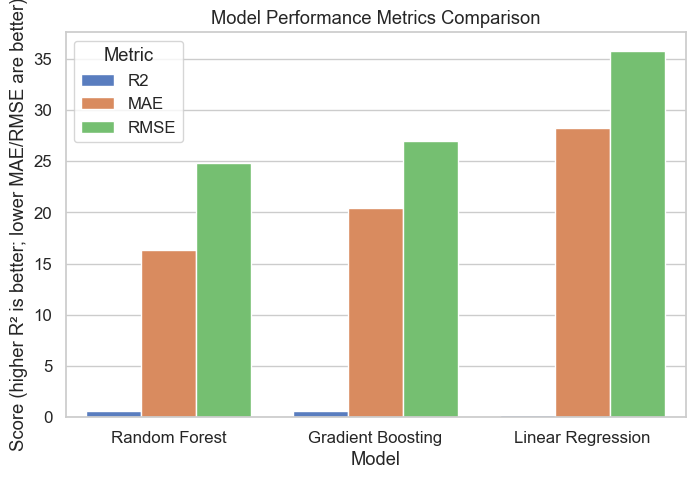

In [14]:
# === Metric Comparison Bar Plot ===
metrics_melted = results_df.melt(id_vars="Model", value_vars=["R2","MAE","RMSE"], var_name="Metric", value_name="Score")

plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Score", hue="Metric", data=metrics_melted)
plt.title("Model Performance Metrics Comparison")
plt.ylabel("Score (higher R² is better; lower MAE/RMSE are better)")
plt.show()


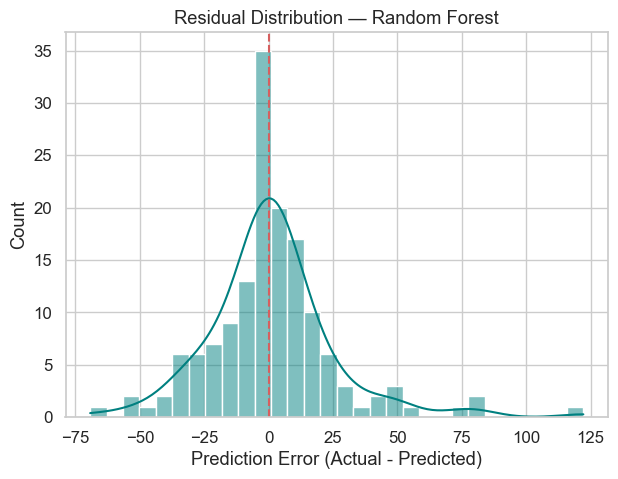

In [15]:
# === Error Distribution for Best Model ===
best_model_name = results_df.loc[0, "Model"]
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)
residuals = y_test - y_pred_best

plt.figure(figsize=(7,5))
sns.histplot(residuals, bins=30, kde=True, color="teal")
plt.title(f"Residual Distribution — {best_model_name}")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.axvline(0, color='r', linestyle='--')
plt.show()
